In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as smf
from scipy import stats

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [4]:
df = pd.read_csv(r"/Users/admin/Desktop/optimization-1/parklane_combined_edited.csv")


In [6]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7) & (df['sys_eff']>=0.4) & (df['sys_eff']<=0.9)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# efficiency column reduce by air system efficiency
fil_df['sys_eff'] = fil_df['sys_eff'] - fil_df['air_eff']

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

# chiller configuration
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# ct approach
fil_df['ct_approach'] = fil_df['h_cwst'] - fil_df['wea_ct_wb']
fil_df = fil_df[fil_df['ct_approach']<=4]

# ct_tot_kw
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=20)]

print("total number of rows after filter is {}".format(len(fil_df)))

total number of rows after filter is 176037


# Feature Extraction

In [27]:
chiller_feats = ["ch_sysef", "h_chwst", "h_chwrt", "h_cwst", "h_cwrt", "h_chwf", "h_cwf", "ct_tot_kw", "lift", "sys_cl"]
df_chiller = fil_df[chiller_feats]
X = df_chiller
y = fil_df[["ch_sysef"]]

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Pearsons Correlation

In [28]:
corr_values = r_regression(X,y)

table_df = pd.DataFrame(
    data=corr_values.reshape(1, -1),
    columns=chiller_feats)
table_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,ch_sysef,h_chwst,h_chwrt,h_cwst,h_cwrt,h_chwf,h_cwf,ct_tot_kw,lift,sys_cl
0,1.0,-0.03925,0.005627,0.381296,0.519589,0.214124,0.092982,0.503081,0.498335,0.311065


## Spearmans Correlation

In [29]:
# spearmans correlation
res_corr = []
for feat in chiller_feats:
    res = stats.spearmanr(fil_df[feat], y)
    res_corr.append(res.statistic)

res_corr = np.array(res_corr)
table_df = pd.DataFrame(
    data=res_corr.reshape(1, -1),
    columns=chiller_feats
)
table_df


,ch_sysef,h_chwst,h_chwrt,h_cwst,h_cwrt,h_chwf,h_cwf,ct_tot_kw,lift,sys_cl
0,1.0,-0.124832,0.008277,0.274111,0.529725,0.196627,0.119989,0.466746,0.521189,0.360247


comment
the last 5 features are the most significant contributor to chiller efficiency
which are cooling tower power inputs, cooling load, heat rejection, power input, normalization isn't necessary for pearson's test

## PCA

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

n_list = [i for i in range(1,11)]
r_squared = {}

for n in n_list:
    pca_n = make_pipeline(PCA(n_components = n), LinearRegression())
    pca_n.fit(X_train, y_train)

    r_squared_value = pca_n.score(X_test, y_test)
    r_squared[n] =  r_squared_value


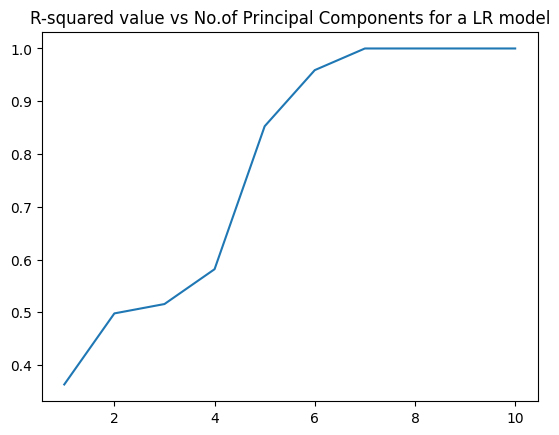

In [31]:
n = r_squared.keys()
values = r_squared.values()
plt.plot(n,values)
plt.title("R-squared value vs No.of Principal Components for a LR model")
plt.show()

In [32]:
pd.set_option('mode.use_inf_as_na', True)


/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_2739/1991739887.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [33]:
five_feat_df = fil_df[["ct_1_kw", "ct_2_kw", "h_cwf", "h_cwrt", "h_chwst", "ch_sysef"]]
five_feat_df = five_feat_df.reset_index(drop=True)

five_feat_df.corr()

In [34]:
fil_df[chiller_feats].corr()

,ch_sysef,h_chwst,h_chwrt,h_cwst,h_cwrt,h_chwf,h_cwf,ct_tot_kw,lift,sys_cl
ch_sysef,1.000000,-0.039250,0.005627,0.381296,0.519589,0.214124,0.092982,0.503081,0.498335,0.311065
h_chwst,-0.039250,1.000000,0.361883,0.086713,0.147070,0.277346,-0.012332,0.023313,-0.420821,0.090159
h_chwrt,0.005627,0.361883,1.000000,-0.329322,0.236908,-0.497127,-0.393831,0.211102,0.016173,0.152444
h_cwst,0.381296,0.086713,-0.329322,1.000000,0.627496,0.665964,0.622897,0.145583,0.527301,0.494264
h_cwrt,0.519589,0.147070,0.236908,0.627496,1.000000,0.323248,0.008895,0.347178,0.835389,0.592378
h_chwf,0.214124,0.277346,-0.497127,0.665964,0.323248,1.000000,0.725137,0.150601,0.142334,0.641012
h_cwf,0.092982,-0.012332,-0.393831,0.622897,0.008895,0.725137,1.000000,0.105943,0.015010,0.589575
ct_tot_kw,0.503081,0.023313,0.211102,0.145583,0.347178,0.150601,0.105943,1.000000,0.305447,0.436213
lift,0.498335,-0.420821,0.016173,0.527301,0.835389,0.142334,0.015010,0.305447,1.000000,0.493178
sys_cl,0.311065,0.090159,0.152444,0.494264,0.592378,0.641012,0.589575,0.436213,0.493178,1.000000


<Axes: >

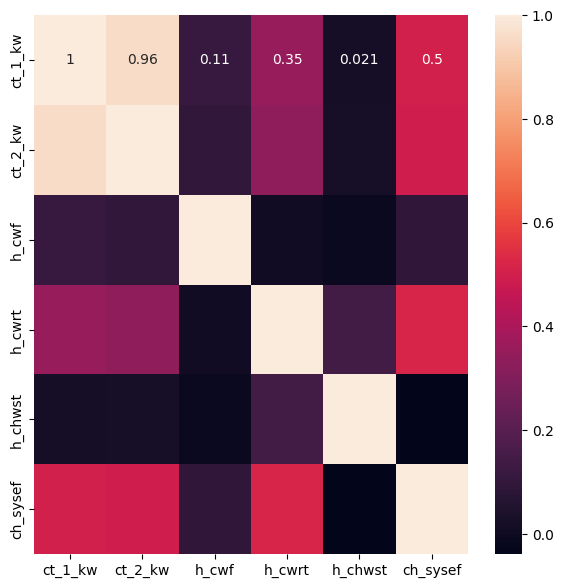

In [35]:
plt.figure(figsize=(7, 7))
sns.heatmap(five_feat_df.corr(), annot=True)

In [36]:
# sns.pairplot(five_feat_df)
# picture in msTeams
fil_df["total_ct_kw"] = fil_df["ct_1_kw"] + fil_df["ct_2_kw"]
fil_df["total_ct_kw"]

646       7.056000
648       7.088001
649       7.104001
650       7.072001
651       7.056001
            ...   
727422    4.320000
727423    4.208000
727424    4.192000
727425    4.096000
727426    4.176000
Name: total_ct_kw, Length: 176037, dtype: float64

In [37]:
# Train Test Split
five_Feat = fil_df[["total_ct_kw", "h_cwf", "h_cwrt", "h_chwst"]] # due to multicollinearity, ct_2_kw is removed
y = fil_df[["ch_sysef"]]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

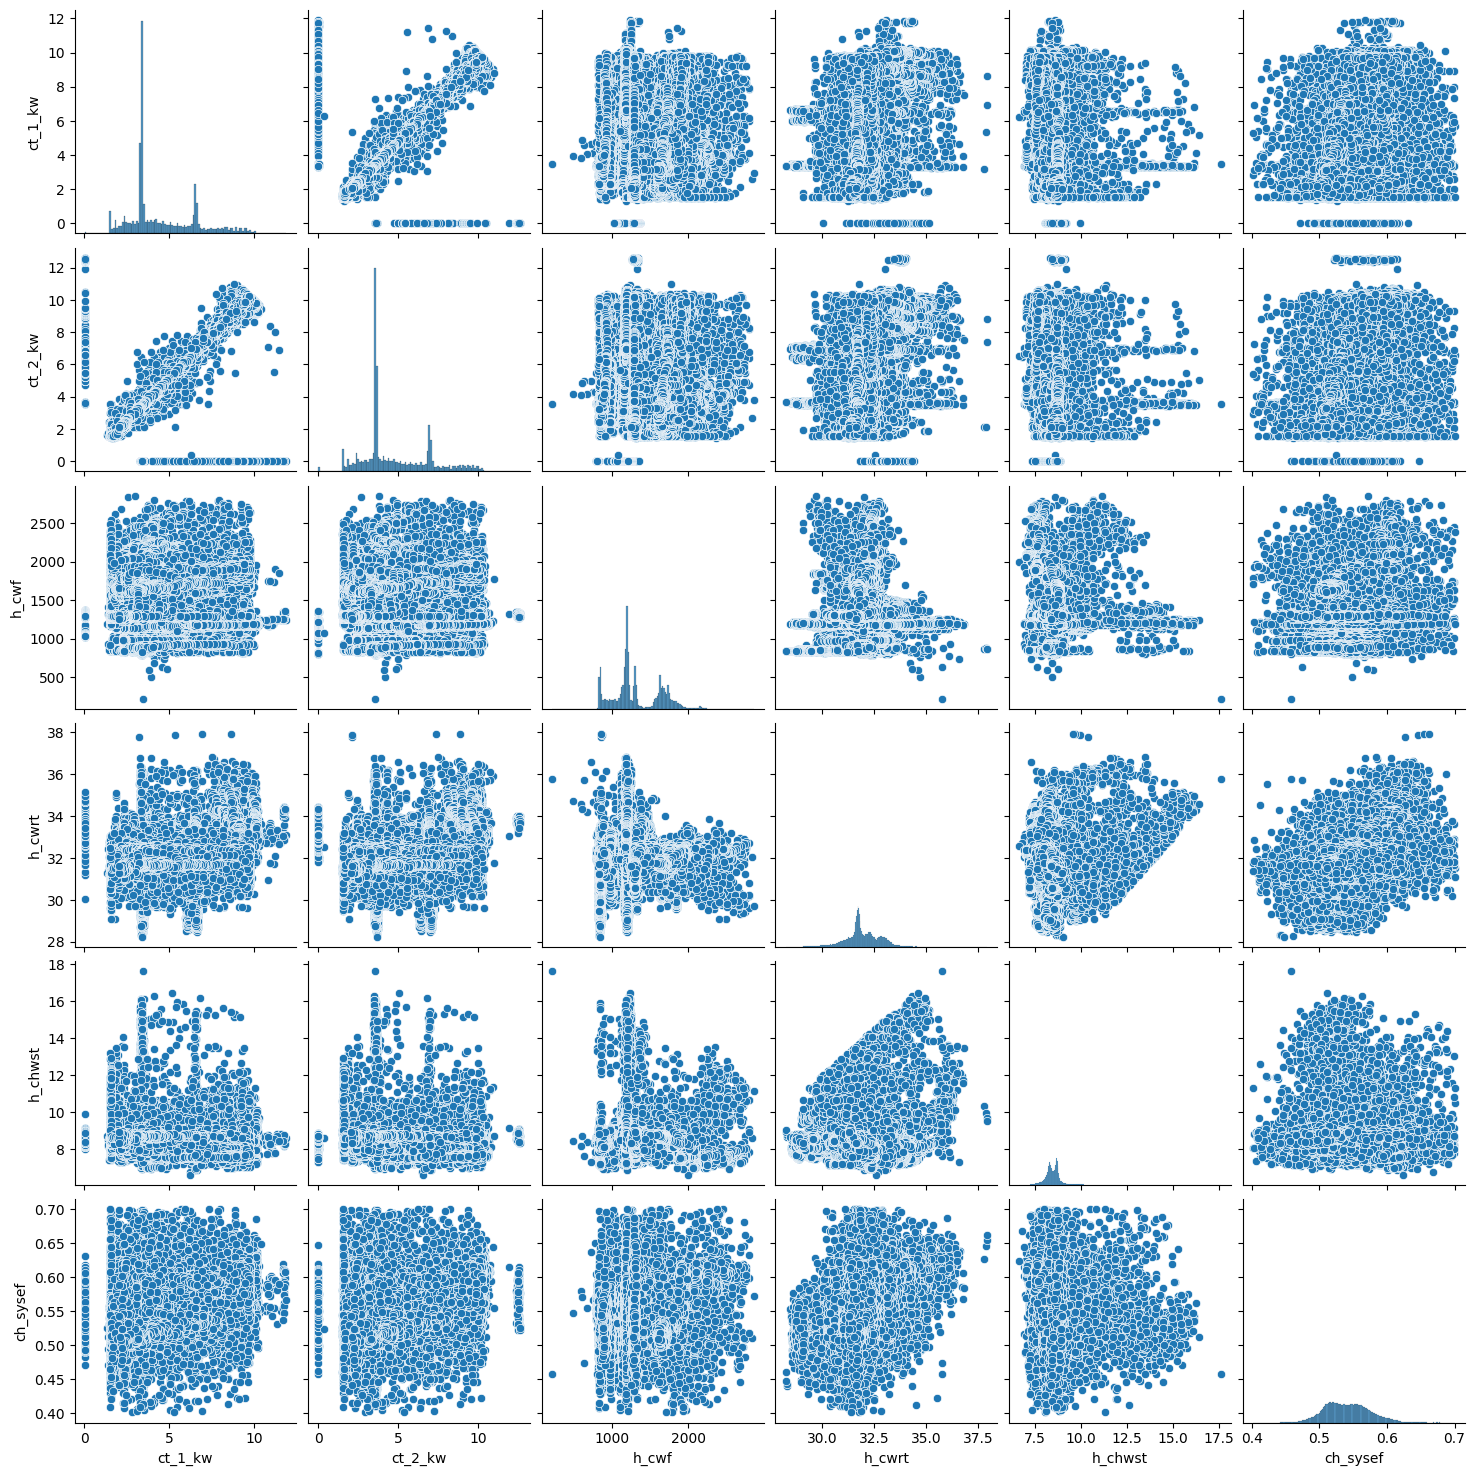

In [38]:
sns.pairplot(five_feat_df)

# Polynomial Regression

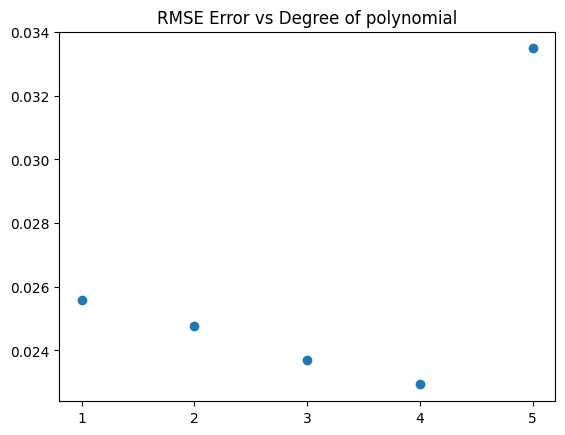

In [39]:
degrees = [i for i in range(1, 6)]
rmse = []
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(five_Feat)
    five_Feat_train, five_Feat_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)

    poly_reg = LinearRegression()
    poly_reg.fit(five_Feat_train, y_train)

    poly_reg_y_predicted = poly_reg.predict(five_Feat_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted)))


plt.scatter(degrees, rmse)
plt.title("RMSE Error vs Degree of polynomial")
plt.xticks(degrees)
plt.show()



In [40]:
# comparison with ordinary LinReg
lin_reg = LinearRegression()
lin_reg.fit(five_Feat_train, y_train)
lin_reg_y_predicted = lin_reg.predict(five_Feat_test)
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_y_predicted))
print("RMSE error for ordinary Linear Regression is {}".format(lin_reg_rmse))

RMSE error for ordinary Linear Regression is 0.03348178399735343


polynomial regression with degree of 1 actually produces lower MSE

# Ridge Regression

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.39633e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.18852e-40): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.55656e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.70062e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.

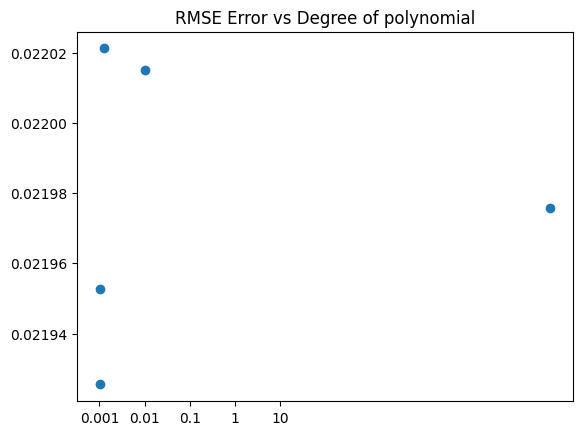

In [41]:
alphas = [0.001, 0.01, 0.1, 1, 10]
rmse = []
for alpha in alphas:
    ridgeReg = Ridge(alpha=alpha)

    ridgeReg.fit(five_Feat_train, y_train)

    ridge_reg_y_predicted = ridgeReg.predict(five_Feat_test)
    ridge_reg_rmse = np.sqrt(mean_squared_error(y_test, ridge_reg_y_predicted))
    
    rmse.append(ridge_reg_rmse)
plt.scatter(alphas, rmse)
plt.title("RMSE Error vs Degree of polynomial")
plt.xticks(range(len(alphas)), alphas)
plt.show()